## Recommendation system for Steam

The Steam platform is the largest digital distribution platform for PC gaming. This project aims to build a recommendation system recommending applications for Steam users.

This project is divided into 4 parts. 
1. Crawl data from steam using API, getting application information.
2. For each user in the given user_id file, find the game list owned by this user.
3. Build recommendation engines based on 4 methods with one of them in spark.  Create 4 corresponding tables and save them into sql.
4. Built a demo with Python Flask.

Preparation:
1. Create a Steam account and obtain a own API key.
2. Create a database "steam" in Mysql.
3. Create a yaml file with mysql username, password, host and database name in it.
4. Connect to Mysql.


### 1. Getting application details from steam.

Import the libraries 

In [2]:
import requests, json, time
import os
import yaml
import pandas as pd
from tqdm import tqdm_notebook as tqdm   ##addressed the new line problem of tqdm in jupyter notebook.
from datetime import datetime
from sqlalchemy import create_engine
from sqlalchemy.types import Integer

Define a function to get application details.

In [3]:
def get_app_details():   
    
    url = 'http://api.steampowered.com/ISteamApps/GetAppList/v2'
    r = requests.get(url)
    dic_steam_app = r.json()
    lst_app_id = [i.get('appid') for i in dic_steam_app.get('applist',{}).get('apps',[])]    
    with open('/Users/liuxin/Documents/data_lab/Game_Recommender/steam_app_details.txt', 'w') as f:
        for app_id in tqdm(sorted(lst_app_id), desc = 'Get App Details'):
            for i in range(3):
                try:
                    r = requests.get(
                        url = 'http://store.steampowered.com/api/appdetails/', 
                        params = { 'appids' : app_id }
                    )
                    dic_app_data = r.json()
                    f.write(json.dumps(dic_app_data))
                    f.write('\n')
                    time.sleep(.5)
                    break
                except Exception as e:
                    print(app_id, e)

Define a function to process the data

In [ ]:
def parse_steam_app_details(app_data):
    developers = ', '.join(app_data.get('developers', []))
    if not developers:
        developers = None
    publishers = ', '.join(app_data.get('publishers', []))
    if not publishers:
        publishers = None
    name = app_data.get('name')
    required_age = app_data.get('required_age')
    short_description = app_data.get('short_description')
    if not short_description:
        short_description = None
    app_type = app_data.get('type')
    header_image = app_data.get('header_image')
    fullgame = app_data.get('fullgame',{}).get('appid')
    lst_categories = app_data.get('categories',[])
    if lst_categories:
        categories = ', '.join([i.get('description') for i in lst_categories])
    else:
        categories = None
    lst_genres = app_data.get('genres',[])
    if lst_genres:
        genres = ', '.join([i.get('description') for i in lst_genres])
    else:
        genres = None
    supported_languages = app_data.get('supported_languages')
    if supported_languages:
        supported_languages = supported_languages.replace('<strong>*</strong>', '').replace('<br>languages with full audio support','')
    if app_data.get('is_free') == True:
        initial_price = 0
        currency = 'USD'
    else:
        if app_data.get('price_overview',{}):
            initial_price = app_data.get('price_overview',{}).get('initial', 0) / 100
            currency = app_data.get('price_overview',{}).get('currency')
        else:
            initial_price = None
            currency = None

    if app_data.get('release_date',{}).get('coming_soon') == False:
        release_date = app_data.get('release_date',{}).get('date')
        if release_date:
            try:
                release_date = datetime.strptime(release_date, '%b %d, %Y').date()
            except Exception as e:
                try:
                    release_date = datetime.strptime(release_date, '%d %b, %Y').date()
                except:
                    try:
                        release_date = datetime.strptime(release_date, '%b %Y').date()
                    except:
                        release_date = None
        else:
            release_date = None
    else:
        release_date = None

    dic_steam_app = {
        'name' : name,
        'type' : app_type,
        'release_date' : release_date,
        'currency' : currency,
        'initial_price' : initial_price,
        'short_description' : short_description,
        'header_image' : header_image,
        'fullgame' : fullgame,
        'developers' : developers,
        'publishers' : publishers,
        'required_age' : required_age,
        'supported_languages' : supported_languages,
        'categories' : categories,
        'genres' : genres,
    }

    return dic_steam_app

Define a function to save the information in sql

In [ ]:
def save_app_details():
    dic_app_details = {}

    config = yaml.safe_load(open('config.yaml'))
    db_username = config['mysql']['username']
    db_password = config['mysql']['password']
    db_endpoint = config['mysql']['endpoint']
    db_database = config['mysql']['database']
    engine = create_engine('mysql+pymysql://{}:{}@{}/{}?charset=utf8mb4'.format(db_username, db_password, db_endpoint, db_database))
	
    with open('/Users/liuxin/Documents/data_lab/recommendation_system/app_detail.csv', 'r') as f:
        for i in tqdm(f.readlines(), desc='Process App Details'):
            try:
                for app_id, dic_response in json.loads(i).items():
                    if dic_response.get('success'):
                        dic_app_details[app_id] = parse_steam_app_details(dic_response.get('data',{}))
            except:
                pass
    df_steam_app = pd.DataFrame.from_dict(dic_app_details, 'index')
    df_steam_app.index.name = 'app_id'
    df_steam_app.reset_index(inplace=True)
    df_steam_app.to_sql('steam_app_details', engine, if_exists='replace', index=False, chunksize = 10000, dtype={'app_id':Integer(), 'required_age':Integer()})

In [ ]:
get_app_details()
save_app_details()

### 2. Getting user owned games 

import libraries

In [ ]:
import re
import os
import threading
import queue
from sqlalchemy import create_engine
from sqlalchemy.types import BigInteger, Integer

Define a function to split list

In [ ]:
def split_list(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

Define functions to get owned games

In [ ]:
def worker_get_owned_games(lst_user_id, api_key, q):
    dic_temp = {}
    for user_id in tqdm(lst_user_id, leave=False, desc='Worker'):
        for i in range(3):
            try:
                r = requests.get(
                    url = 'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/', 
                    params = {
                        'key' : api_key,
                        'steamid' : user_id,
                        'include_played_free_games': True,
                        'format' : 'json' 
                    }
                )
                dic_owned_games = r.json().get('response').get('games')
                dic_temp[user_id] = dic_owned_games
                time.sleep(.5)
                break
            except Exception as e:
                print(user_id, e)
                time.sleep(5) 

    q.put(dic_temp)



Here, we use multi-threading which enables us to write in a way where multiple activities can proceed concurrently in the same program, thereby saving time.

In [ ]:
def get_owned_games(api_key):

    dic_owned_games = {}

    with open('data/steam_user_id.txt', 'r') as f:
        lst_user_id = [i.strip() for i in f.readlines()]

    for lst_user_id_chunk in tqdm(list(split_list(lst_user_id, 500)), desc = 'Get Owned Games'):
        lst_thread = []
        q = queue.Queue()

        for i in list(split_list(lst_user_id_chunk, 100)):
            t = threading.Thread(target = worker_get_owned_games, args = (i, api_key, q,))
            lst_thread.append(t)

        for i in lst_thread:
            i.start()
        
        for i in lst_thread:
            i.join()

        while not q.empty():
            dic_owned_games.update(q.get())

    with open('/Users/liuxin/Documents/data_lab/Game_Recommender/steam_owned_games.txt', 'w') as f:
        for k,v in dic_owned_games.items():
            f.write(json.dumps({k:v}))
            f.write('\n')

Define a function to save the table.

In [ ]:
def save_owned_games(engine):
    dic_owned_games = {}
    with open('/Users/liuxin/Documents/data_lab/Game_Recommender/steam_owned_games.txt', 'r') as f:
        for raw_string in tqdm(f.readlines(), desc='Process Owned Games'):
            user_id, lst_inventory = list(json.loads(raw_string).items())[0]
            if lst_inventory:
                for i in lst_inventory:
                    app_id = i.get('appid')
                    playtime_forever = i.get('playtime_forever', 0)
                    if playtime_forever > 0:
                        dic_owned_games.update({
                            (user_id, app_id) : {
                                'user_id' : user_id,
                                'app_id' : app_id,
                                'playtime_forever' : playtime_forever
                            }
                        })
    df_owned_games = pd.DataFrame.from_dict(dic_owned_games, 'index')   ##orient='index' means using dictionary keys as rows
    df_owned_games.to_sql(
        'steam_owned_games', 
        engine, 
        if_exists='replace', 
        index=False, 
        dtype={
            'user_id': BigInteger(),
            'app_id': Integer(),
            'playtime_forever': Integer()
        }, 
        chunksize = 10000
    )

In [ ]:
get_owned_games(api_key)
save_owned_games(engine)

### Build recommendation engines

import libraries

In [ ]:
from bs4 import BeautifulSoup
from sqlalchemy import create_engine

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
from sklearn.cluster import KMeans

from pyspark.ml.recommendation import ALS
from pyspark import SparkContext
from pyspark.sql import SparkSession

Build the recommendation_popularity_based engine, which only depends on the popularity of applications. 

In [ ]:
def recommendation_popularity_based(engine):
    url = 'https://store.steampowered.com/stats'
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    dic_current_player = {}

    for i in soup.find('div', {'id':'detailStats'}).find_all('tr', {'class':'player_count_row'}):
        lst_data = i.find_all('td')
        current_player = int(lst_data[0].span.string.replace(',',''))
        peak_today = int(lst_data[1].span.string.replace(',',''))
        app_id = re.findall(r'(\d+)', lst_data[-1].a.get('href'))[0]
        dic_current_player[app_id] = {'current_player' : current_player, 'peak_today' : peak_today}

    df_popularity_based_result = pd.DataFrame.from_dict(dic_current_player, 'index')
    df_popularity_based_result.index.name = 'app_id'
    df_popularity_based_result.reset_index(inplace=True)
    df_popularity_based_result.to_sql('recommended_games_popularity_based', engine, if_exists='replace', index = False)

Build the recommendation_content_based engine.
 Content_based engine is determined by the cosine_similarities of the game descriptions.

Here, we use the td-idf method to build the vocabulary.

In [6]:
def recommendation_content_based(engine):

    df_game_description = pd.read_sql_query(
        '''
            SELECT 
                app_id, 
                short_description 
            FROM steam_app_details 
            WHERE short_description IS NOT NULL
            AND type = "game" 
            AND name IS NOT NULL
            AND release_date <= CURDATE() 
            AND initial_price IS NOT NULL
        ''', engine)

    tfidf = TfidfVectorizer(strip_accents='unicode',stop_words='english').fit_transform(df_game_description['short_description'].tolist())

    lst_app_id = df_game_description['app_id'].tolist()
    dic_recomended = {}
    for row_index in tqdm(range(tfidf.shape[0]), desc = 'Model 2: Content Based'):
        cosine_similarities = linear_kernel(tfidf[row_index:row_index+1], tfidf).flatten()
        top_related_rows = cosine_similarities.argsort()[-2:-22:-1]
        dic_recomended.update({lst_app_id[row_index]:[lst_app_id[i] for i in top_related_rows]})


    df_content_based_results = pd.DataFrame.from_dict(dic_recomended, 'index')
    df_content_based_results.index.name = 'app_id'
    df_content_based_results.reset_index(inplace=True)
    df_content_based_results.to_sql('recommended_games_content_based',engine,if_exists='replace', index = False)

Build the recommendation_item_based engine. 

This engine is determined by the cosine_similarity of two users, and it will recommend items owned by the user who shares most similarities with the given user.

In [ ]:
def recommendation_item_based(engine):

    df_purchase = pd.read_sql_query(     
        ''' 
        SELECT app_id, user_id         
        FROM steam_owned_games
        WHERE playtime_forever > 15
        ''', engine).pivot_table(values = 'user_id', index = ['app_id'], columns = ['user_id'], aggfunc = len, fill_value = 0)

    purchase_matrix = df_purchase.values
    lst_app_id = df_purchase.index

    dic_recomended_item_based = {}
    for index in tqdm(range(purchase_matrix.shape[0]), desc = 'Model 3: Item Based'):
        cosine_similarities = linear_kernel(purchase_matrix[index:index+1], purchase_matrix).flatten()
        lst_related_app = np.argsort(-cosine_similarities)[1:101]
        dic_recomended_item_based.update({lst_app_id[index]:[lst_app_id[i] for i in lst_related_app]})

    df_item_based_result = pd.DataFrame.from_dict(dic_recomended_item_based, 'index')
    df_item_based_result.index.name = 'app_id'
    df_item_based_result.reset_index(inplace=True)
    df_item_based_result.to_sql('recommended_games_item_based', engine, if_exists='replace', chunksize = 1000, index = False)

Build the recommendation_als_based engine.

The alternating least squares (ALS) algorithm factorizes a given matrix R into two factors U and V such that R≈UTV. The matrices U and V can be called user and item matrix, respectively. 
In order to find the user and item matrix, the following problem is solved:
$$
argmin_{U,V}∑_{i,j∣r_{i,j}≠0}(r_{i,j}−u^T_iv_j)^2+λ(∑_in_{u_i}‖u_i‖^2+∑_jn_{vj}‖v_j‖^2)
$$
with λ being the regularization factor, nui being the number of items the user i has rated and nvj being the number of times the item j has been rated. This regularization scheme to avoid overfitting is called weighted-λ-regularization. 

By fixing one of the matrices U or V, we obtain a quadratic form which can be solved directly. The solution of the modified problem is guaranteed to monotonically decrease the overall cost function. By applying this step alternately to the matrices U and V, we can iteratively improve the matrix factorization.

The matrix R is given in its sparse representation as a tuple of (i,j,r) where i denotes the row index, j the column index and r is the matrix value at position (i,j).


### Remark:
Here, we use pyspark to create temporary tables for saving memory usage and also utilize the pyspark.ml package.

Preparation:
1. DownLoad and install Java8.
2. DownLoad and install Spark.
3. Set python environment variables. 
4. Download the SQL connector to Java.

### Tips:
We can also transfrom the pyspark.sql.DataFrame to pandas.dataframe and store the table in sql.


In [ ]:
def recommendation_als_based(engine):

    config = yaml.safe_load(open('{}/config.yaml'.format(os.path.dirname(os.path.realpath(__file__)))))  
    db_username = config['mysql']['username']
    db_password = config['mysql']['password']
    db_endpoint = config['mysql']['endpoint']
    db_database = config['mysql']['database']


    sc = SparkContext()
    spark = SparkSession(sc)

    ##create temporary table：
    spark.read.format("jdbc").option("url", "jdbc:mysql://{}/{}".format(db_endpoint, db_database))\
                .option("user", db_username).option("password", db_password)\
                .option("dbtable", "steam_owned_games")\
                .option("driver", "com.mysql.cj.jdbc.Driver")\
                .load().createOrReplaceTempView('user_inventory')



    spark.read.format("jdbc").option("url", "jdbc:mysql://{}/{}".format(db_endpoint, db_database))\
                .option("user", db_username).option("password", db_password)\
                .option("dbtable", "steam_app_details")\
                .option("driver", "com.mysql.cj.jdbc.Driver")\
                .load().createOrReplaceTempView('game_steam_app')


    df_user_playtime = spark.sql('''
        SELECT 
            DENSE_RANK() OVER (ORDER BY user_id) AS user, 
            user_id, 
            app_id AS item, 
            LOG(playtime_forever) AS rating 
        FROM user_inventory
        WHERE playtime_forever >= 5
    ''')

    df_valid_games = spark.sql('''
        SELECT app_id 
        FROM game_steam_app 
        WHERE short_description IS NOT NULL 
        AND name IS NOT NULL 
        AND type = "game" 
        AND initial_price IS NOT NULL
    ''')
    df_user_inventory = df_user_playtime.join(df_valid_games, df_user_playtime['item'] == df_valid_games['app_id'], 'inner').select('user','user_id','item','rating')

    dic_real_user_id = df_user_inventory.select('user','user_id').toPandas().set_index('user')['user_id'].to_dict()
    als = ALS(rank = 10)
    model = als.fit(df_user_inventory)
    recommended_games = model.recommendForAllUsers(10)
    dic_recomended_als_based = {}
    for user, lst_recommended_games in tqdm(recommended_games.select('user', 'recommendations.item').toPandas().set_index('user')['item'].to_dict().items(),desc = 'Model 4: Content Based'):
        user_id = dic_real_user_id.get(user)
        dic_recomended_als_based[user_id] = {}
        for i, app_id in enumerate(lst_recommended_games):
            dic_recomended_als_based[user_id].update({i:app_id})


    df_als_based_result = pd.DataFrame.from_dict(dic_recomended_als_based, 'index')
    df_als_based_result.index.name = 'user_id'
    df_als_based_result.reset_index(inplace=True)
    df_als_based_result.to_sql('recommended_games_als_based', engine, if_exists='replace', chunksize = 1000, index = False)

In [ ]:
recommendation_popularity_based(engine)
recommendation_content_based(engine)
recommendation_item_based(engine)
recommendation_als_based(engine)

### Built a demo with Python Flask.

In [ ]:
from flask import Flask, render_template
import random
from sqlalchemy import create_engine

In [ ]:
app = Flask(__name__)

In [ ]:
with open('/Users/liuxin/Documents/data_lab/Game_Recommender/data/steam_user_id.txt','r') as f:
    lst_user_id = f.readlines()

In [ ]:
lst_popular_games = engine.execute('''
	SELECT 
		game_steam_app.app_id, 
		game_steam_app.name, 
		game_steam_app.initial_price, 
		game_steam_app.header_image 
	FROM game_steam_app
	JOIN recommended_games_popularity_based 
	ON game_steam_app.app_id = recommended_games_popularity_based.app_id
	AND game_steam_app.type = "game" 
	AND game_steam_app.release_date <= CURDATE() 
	AND game_steam_app.initial_price IS NOT NULL
	ORDER BY recommended_games_popularity_based.peak_today DESC 
	LIMIT 5''').fetchall()

In [ ]:
@app.route('/')
def recommender():
	user_id = random.choice(lst_user_id)


	lst_most_played_games = engine.execute('''
		SELECT 
			game_steam_app.app_id, 
			game_steam_app.name, 
			game_steam_app.initial_price, 
			game_steam_app.header_image 
		FROM game_steam_app
		JOIN user_inventory 
		ON game_steam_app.app_id = user_inventory.app_id
		WHERE user_inventory.user_id = {} 
		AND user_inventory.playtime_forever > 0 
		AND game_steam_app.type = "game" 
		AND game_steam_app.release_date <= CURDATE() 
		AND game_steam_app.initial_price IS NOT NULL
		ORDER BY user_inventory.playtime_forever DESC 
		LIMIT 3'''.format(user_id)).fetchall()



	if lst_most_played_games:
		favorite_app_id = lst_most_played_games[0][0]
		# get content based recommendation
		lst_content_recommended = engine.execute('''
			SELECT app_id, name, initial_price, header_image 
			FROM game_steam_app 
			WHERE type = "game" 
			AND release_date <= CURDATE() 
			AND initial_price IS NOT NULL
			AND app_id IN ({})'''.format(','.join(
				[str(i) for i in engine.execute('SELECT `0`,`1`,`2` FROM recommended_games_content_based WHERE app_id = {}'.format(favorite_app_id)).first()]
				)
			)
		).fetchall()


		# get item based recommendation
		lst_item_recommended = engine.execute('''
			SELECT app_id, name, initial_price, header_image 
			FROM game_steam_app 
			WHERE type = "game" 
			AND release_date <= CURDATE() 
			AND initial_price IS NOT NULL
			AND app_id IN ({})'''.format(','.join(
				[str(i) for i in engine.execute('SELECT `0`,`1`,`2` FROM recommended_games_item_based WHERE app_id = {}'.format(favorite_app_id)).first()]
				)
			)
		).fetchall()


		#get ALS based recommendation
		lst_als_recommended = engine.execute('''
			SELECT app_id, name, initial_price, header_image
			FROM game_steam_app
			WHERE type = "game"
			AND release_date <= CURDATE()
			AND initial_price IS NOT NULL
			AND app_id IN ({})'''.format(','.join(
				[str(i) for i in engine.execute('SELECT `0`,`1`,`2` FROM recommended_games_als_based WHERE user_id = {}'.format(user_id)).first()]
				)
			)
		).fetchall()

	else:
		lst_content_recommended = []
		lst_item_recommended = []
		lst_als_recommended = []




	return render_template( 'recommendation.html',
							user_id = user_id,
							lst_most_played_games = lst_most_played_games,
							lst_content_recommended = lst_content_recommended,
							lst_item_recommended = lst_item_recommended,
							lst_als_recommended = lst_als_recommended,
							lst_popular_games = lst_popular_games)

In [ ]:
app.run(debug=True)

### A screenshot of the demo.
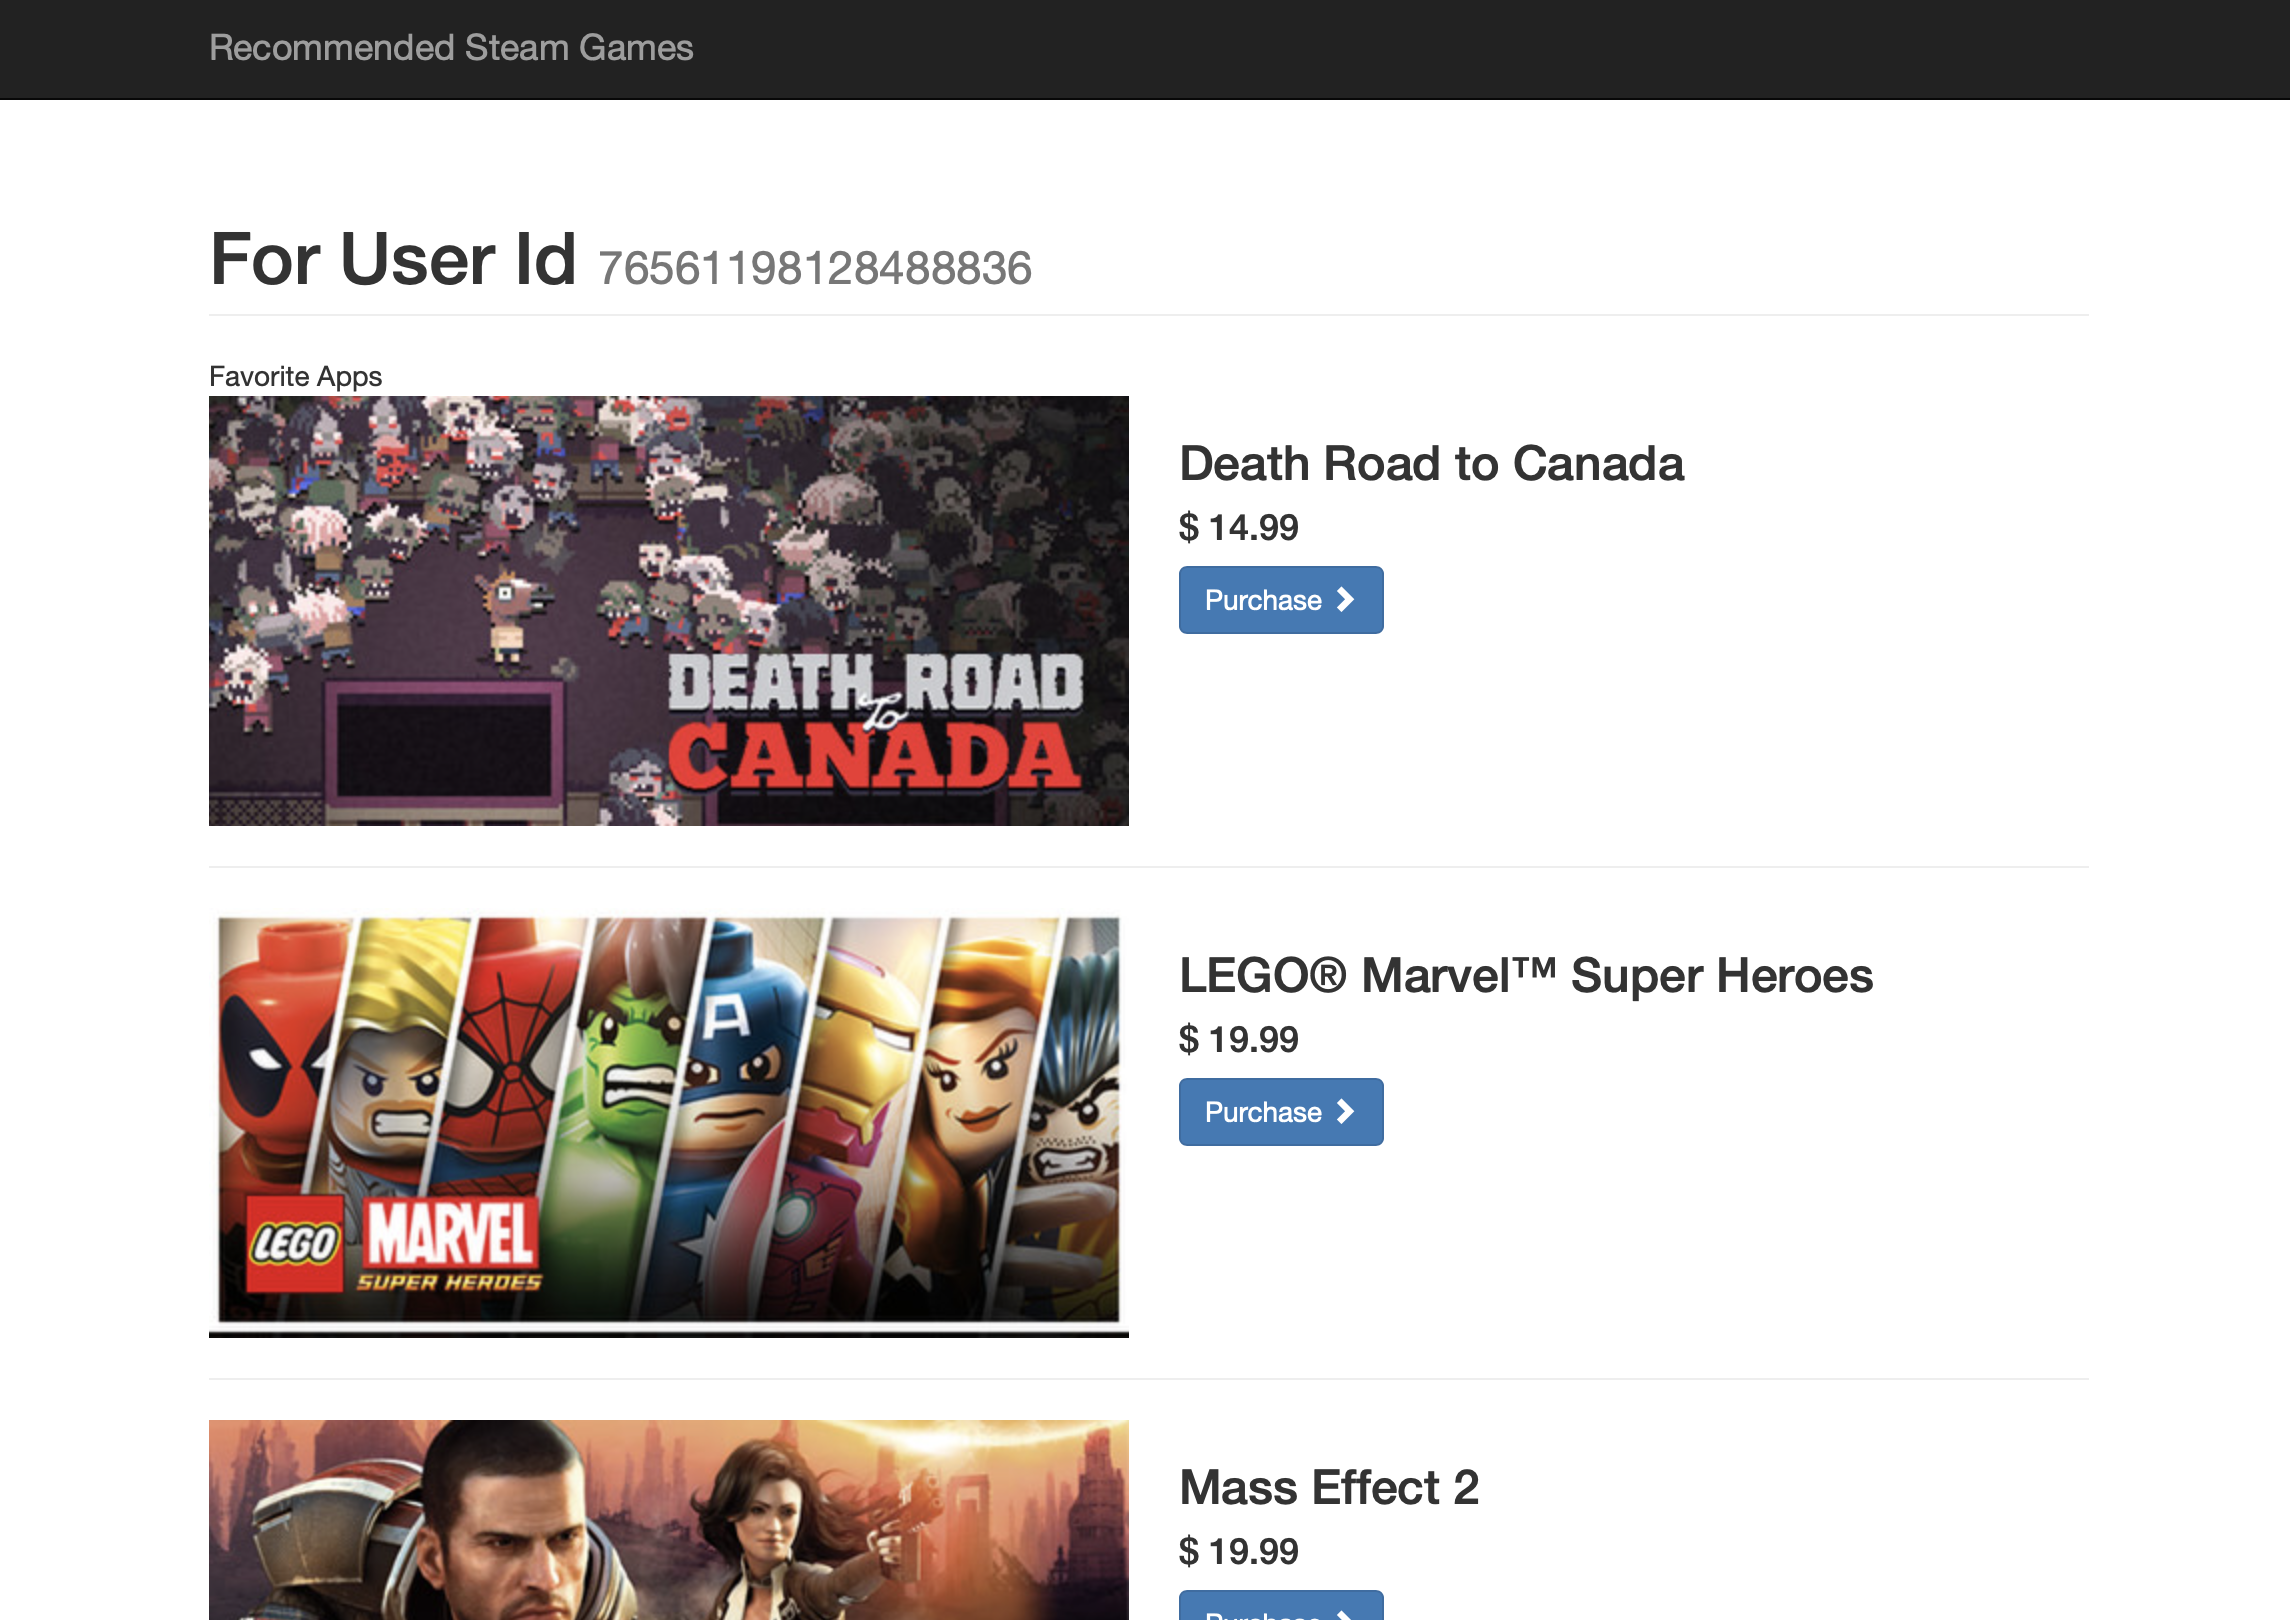